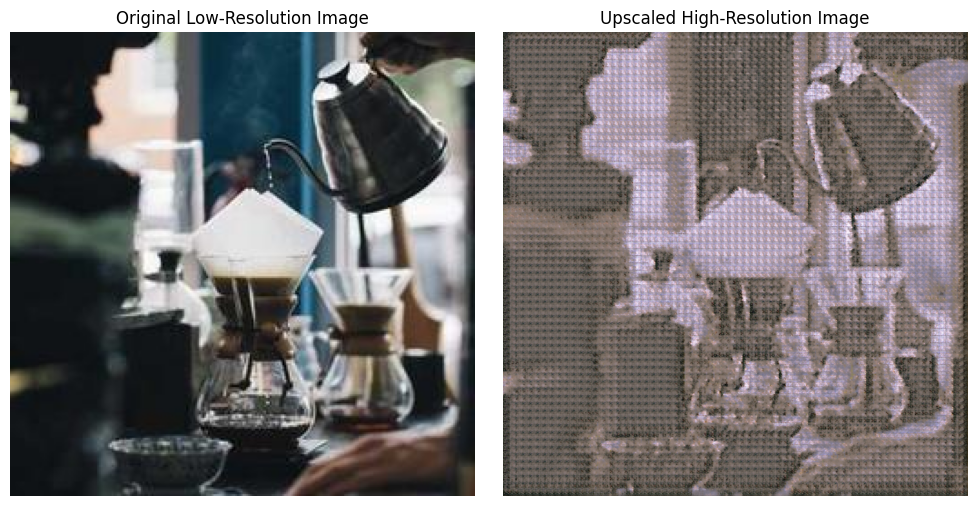

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

# Define the ESRGAN model
class ESRGANGenerator(nn.Module):
    def __init__(self, scale_factor=4):
        super(ESRGANGenerator, self).__init__()
        self.scale_factor = scale_factor
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),

            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),

            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),

            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),

            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),

            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained generator
generator = ESRGANGenerator().to(device)
generator.load_state_dict(torch.load("esrgan_generator.pth"))
generator.eval()

url = "https://picsum.photos/256"  # URL for a random 256x256 image
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Upscale the image using the trained generator
with torch.no_grad():
    upscaled_image = generator(image_tensor)

# Postprocess the upscaled image
upscaled_image = upscaled_image.squeeze(0).cpu().detach()
upscaled_image = (upscaled_image * 0.5 + 0.5).clamp(0, 1)
upscaled_image = transforms.ToPILImage()(upscaled_image)

# Display the original and upscaled images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax1.set_title("Original Low-Resolution Image")
ax1.axis("off")
ax2.imshow(upscaled_image)
ax2.set_title("Upscaled High-Resolution Image")
ax2.axis("off")
plt.tight_layout()
plt.show()